# Задание 3: Разведочный анализ

Данные наблюдений за видами (когда и где наблюдается данный вид) типичны для исследований биоразнообразия. 
Крупные международные инициативы поддерживают сбор этих данных волонтерами, например, iNaturalist. 
Благодаря таким инициативам, как GBIF, многие из этих данных также находятся в открытом доступе.

Вы решили поделиться данными полевой кампании, но набор данных все еще требует некоторой очистки и стандартизации. 
Например, координаты могут называться x/y, decimalLatitude/decimalLongitude, lat/long ... 
К счастью, вы знаете о международном стандарте открытых данных для описания данных о событиях/наблюдениях, т.е. Darwin Core (DwC). 
Вместо того, чтобы изобретать собственную модель данных, вы решаете соответствовать этому международному стандарту. 
Последнее улучшит коммуникацию, а также сделает ваши данные совместимыми с GBIF.

Короче говоря, DwC описывает плоскую таблицу (CSV) с согласованным соглашением об именах для имен заголовков и соглашениями о том, как должны быть представлены определенные типы данных (для справки, подробное описание дано здесь). 
В этом руководстве мы сосредоточимся на нескольких существующих терминах, чтобы изучить некоторые элементы очистки данных:

- eventDate : формат дат ISO 6801
- ScientificName : общепринятое научное название вида.
- decimalLatitude / decimalLongitude : координаты вхождения в формате WGS84
- sex: либо мужской , либо женский , чтобы охарактеризовать пол события
- instanceID : идентификатор в наборе данных для идентификации отдельных записей.
- datasetName : статическая строка, определяющая источник данных

Кроме того, дополнительная информация о таксономии будет добавлена с использованием внешнего API-сервиса.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyproj import Transformer
from calendar import day_abbr


In [2]:
survey_filename = "..\\..\\data\\003\\surveys.csv"
survey_data = pd.read_csv(survey_filename, sep=",")
#survey_data.head()

In [3]:
'''
Упражнение 1
Сколько уникальных записей содержит набор данных?
'''
#survey_data.count()
survey_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35549 entries, 0 to 35548
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   record_id  35549 non-null  int64  
 1   month      35549 non-null  int64  
 2   day        35549 non-null  int64  
 3   year       35549 non-null  int64  
 4   plot       35549 non-null  int64  
 5   species    33534 non-null  object 
 6   sex_char   33042 non-null  object 
 7   wgt        32283 non-null  float64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.2+ MB


In [4]:
'''
УПРАЖНЕНИЕ 2
Добавьте новый столбец datasetName в набор данных опроса с datasetname в качестве значения для всех записей (статическое значение для всего набора данных).
'''
survey_data["datasetname"] = "Ecological Archives E090-118-D1."

survey_data.head()

,record_id,month,day,year,plot,species,sex_char,wgt,datasetname
0,1,7,16,1977,2,NaN,M,NaN,Ecological Archives E090-118-D1.
1,2,7,16,1977,3,NaN,M,NaN,Ecological Archives E090-118-D1.
2,3,7,16,1977,2,DM,F,NaN,Ecological Archives E090-118-D1.
3,4,7,16,1977,7,DM,M,NaN,Ecological Archives E090-118-D1.
4,5,7,16,1977,3,DM,M,NaN,Ecological Archives E090-118-D1.


In [5]:
'''
УПРАЖНЕНИЕ 3
Получите список уникальных значений для столбца sex_char.
'''

survey_data["sex_char"].unique()

array(['M', 'F', nan, 'R', 'P', 'Z'], dtype=object)

In [6]:
survey_data = survey_data.rename(columns={'sex_char': 'verbatimSex'})
survey_data.head()


,record_id,month,day,year,plot,species,verbatimSex,wgt,datasetname
0,1,7,16,1977,2,NaN,M,NaN,Ecological Archives E090-118-D1.
1,2,7,16,1977,3,NaN,M,NaN,Ecological Archives E090-118-D1.
2,3,7,16,1977,2,DM,F,NaN,Ecological Archives E090-118-D1.
3,4,7,16,1977,7,DM,M,NaN,Ecological Archives E090-118-D1.
4,5,7,16,1977,3,DM,M,NaN,Ecological Archives E090-118-D1.


In [7]:
'''
УПРАЖНЕНИЕ 4
Выразите отображение значений (например, M -> male) в объект словаря Python с именем переменной sex_dict. Значения Z соответствуют Not a Number, который можно определить как np.nan.
Используйте словарь sex_dict, чтобы заменить значения в столбце verbatimSex новыми значениями и сохранить сопоставленные значения в новом столбце «пол» кадра данных.
'''

sex_dict = dict({'M': 'male', 'F': 'female', 'nan': np.nan, 'Z': np.nan, 'R' : 'male', 'P': 'female'})
survey_data["sex"] = survey_data["verbatimSex"].map(sex_dict)

survey_data["sex"].unique()

array(['male', 'female', nan], dtype=object)

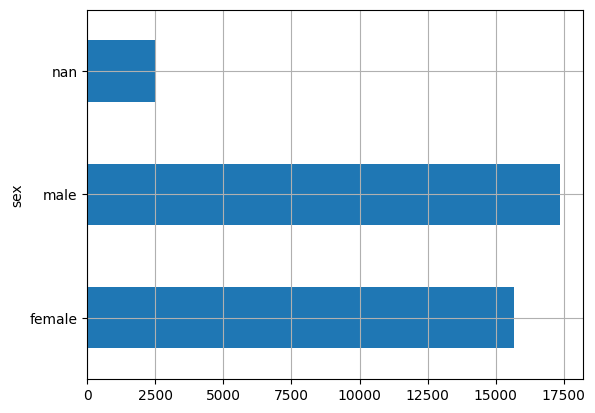

In [8]:
'''
УПРАЖНЕНИЕ 5
Создайте горизонтальную гистограмму, сравнивая количество записей о мужчинах, женщинах и неизвестных (NaN) в наборе данных.
'''

grouped1 = survey_data.groupby("sex", dropna=False).count()["record_id"]
#grouped1.head()
grouped1.plot.barh(grid=True, legend=False)
plt.show()


In [9]:
survey_data["species"].unique()
#survey_data.head(10)


array([nan, 'DM', 'PF', 'PE', 'DM and SH', 'DS', 'PP', 'SH', 'OT', 'DO',
       'OX', 'SS', 'OL', 'RM', 'SA', 'PM', 'AH', 'DX', 'AB', 'CB', 'CM',
       'CQ', 'RF', 'PC', 'PG', 'PH', 'PU', 'CV', 'UR', 'UP', 'ZL', 'UL',
       'CS', 'SC', 'BA', 'SF', 'RO', 'AS', 'SO', 'PI', 'ST', 'CU', 'SU',
       'RX', 'PB', 'PL', 'PX', 'CT', 'US'], dtype=object)

In [10]:
def solve_double_field_entry(df, keyword="and", column="verbatimEventDate"):
    """ Разделить по ключевому слову в столбце для перечисления и создать дополнительную запись

    Параметры
    ----------
    df: pd.DataFrame
    DataFrame с двойной записью поля в одном или нескольких значениях
    keyword: str
    слово/символ для разделения двойные записи в
    column: имя столбца str
    для разделения записей
    """
    
    df = df.copy() # copy the input DataFrame to avoid editing the original
    df[column] = df[column].str.split(keyword)
    df = df.explode(column)
    df[column] = df[column].str.strip() # remove white space around the words
    return df

In [11]:
'''
УПРАЖНЕНИЕ 6
Используйте функцию solve_double_field_entry, чтобы обновить данные обзора, отделив двойные записи. 
Сохраните результат как переменную survey_data_decoupled.
'''

survey_data_decoupled = solve_double_field_entry(survey_data, keyword = "and", column = "species")
#survey_data_decoupled["species"].unique()
survey_data_decoupled.head(10)


,record_id,month,day,year,plot,species,verbatimSex,wgt,datasetname,sex
0,1,7,16,1977,2,NaN,M,NaN,Ecological Archives E090-118-D1.,male
1,2,7,16,1977,3,NaN,M,NaN,Ecological Archives E090-118-D1.,male
2,3,7,16,1977,2,DM,F,NaN,Ecological Archives E090-118-D1.,female
3,4,7,16,1977,7,DM,M,NaN,Ecological Archives E090-118-D1.,male
4,5,7,16,1977,3,DM,M,NaN,Ecological Archives E090-118-D1.,male
5,6,7,16,1977,1,PF,M,NaN,Ecological Archives E090-118-D1.,male
6,7,7,16,1977,2,PE,F,NaN,Ecological Archives E090-118-D1.,female
7,8,7,16,1977,1,DM,M,NaN,Ecological Archives E090-118-D1.,male
8,9,7,16,1977,1,DM,NaN,NaN,Ecological Archives E090-118-D1.,NaN
8,9,7,16,1977,1,SH,NaN,NaN,Ecological Archives E090-118-D1.,NaN


In [12]:
survey_data_decoupled["occurrence_id"] = np.arange(1, len(survey_data_decoupled) + 1, 1)
survey_data_decoupled = survey_data_decoupled.drop(columns="record_id")
survey_data_decoupled.head(10)


,month,day,year,plot,species,verbatimSex,wgt,datasetname,sex,occurrence_id
0,7,16,1977,2,NaN,M,NaN,Ecological Archives E090-118-D1.,male,1
1,7,16,1977,3,NaN,M,NaN,Ecological Archives E090-118-D1.,male,2
2,7,16,1977,2,DM,F,NaN,Ecological Archives E090-118-D1.,female,3
3,7,16,1977,7,DM,M,NaN,Ecological Archives E090-118-D1.,male,4
4,7,16,1977,3,DM,M,NaN,Ecological Archives E090-118-D1.,male,5
5,7,16,1977,1,PF,M,NaN,Ecological Archives E090-118-D1.,male,6
6,7,16,1977,2,PE,F,NaN,Ecological Archives E090-118-D1.,female,7
7,7,16,1977,1,DM,M,NaN,Ecological Archives E090-118-D1.,male,8
8,7,16,1977,1,DM,NaN,NaN,Ecological Archives E090-118-D1.,NaN,9
8,7,16,1977,1,SH,NaN,NaN,Ecological Archives E090-118-D1.,NaN,10


In [13]:
'''
УПРАЖНЕНИЕ 7

Сделайте выборку survey_data_decoupled, содержащую те записи, которые не могут быть правильно интерпретированы как значения даты, и сохраните полученный DataFrame как новую переменную trouble_makers.
'''

markers = pd.to_datetime(survey_data_decoupled[["year", "month", "day"]], errors='coerce').isna()
trouble_makers = survey_data_decoupled[markers]

trouble_makers.head()
#trouble_makers["day"].unique()
#trouble_makers["month"].unique()
#trouble_makers["year"].unique()


,month,day,year,plot,species,verbatimSex,wgt,datasetname,sex,occurrence_id
30649,4,31,2000,6,PP,F,19.0,Ecological Archives E090-118-D1.,female,30651
30650,4,31,2000,6,PB,M,32.0,Ecological Archives E090-118-D1.,male,30652
30651,4,31,2000,6,PB,F,30.0,Ecological Archives E090-118-D1.,female,30653
30652,4,31,2000,6,PP,M,20.0,Ecological Archives E090-118-D1.,male,30654
30653,4,31,2000,6,PP,M,24.0,Ecological Archives E090-118-D1.,male,30655


In [14]:
'''
#### УПРАЖНЕНИЕ 8
Присвойте во фрейме данных survey_data_decoupled всем значениям дня нарушителей спокойствия значение 30 вместо 31.
'''
survey_data_decoupled.loc[markers, ["day"]] = 30

# check
pd.to_datetime(survey_data_decoupled[["year", "month", "day"]], errors='coerce').isna().sum()

0

In [15]:
survey_data_decoupled["eventDate"] = pd.to_datetime(survey_data_decoupled[["year", "month", "day"]])
survey_data_decoupled = survey_data_decoupled.drop(columns=["day", "month", "year"])

survey_data_decoupled[ "eventDate" ].dtype


dtype('<M8[ns]')

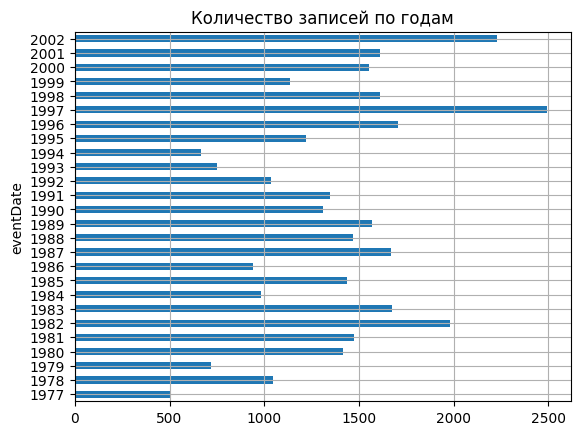

In [16]:
'''
УПРАЖНЕНИЕ 10

Создайте горизонтальную гистограмму с количеством записей для каждого года, 
но без использования столбца года, используя непосредственно столбец eventDate.
'''

grouped1 = survey_data_decoupled.groupby(survey_data_decoupled["eventDate"].dt.year, dropna=False).count()["occurrence_id"]
#grouped1.head()
grouped1.plot.barh(grid=True, legend=False, title="Количество записей по годам")
plt.show()


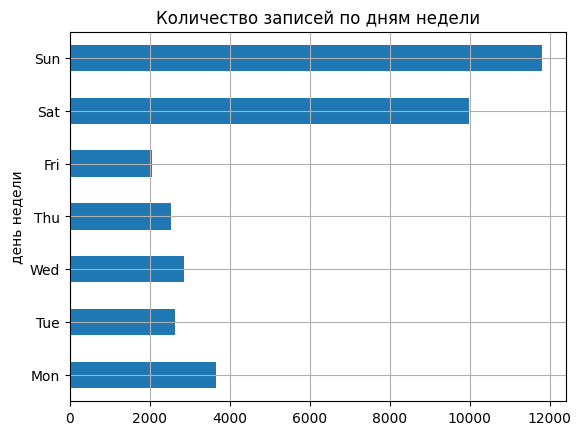

In [17]:
'''
УПРАЖНЕНИЕ 11
Создайте гистограмму с количеством записей для каждого дня недели (dayofweek)
'''

grouped1 = survey_data_decoupled.groupby(survey_data_decoupled["eventDate"].dt.dayofweek, dropna=False).count()["occurrence_id"]
#grouped1.head()

ax = grouped1.plot.barh(grid=True, legend=False, title="Количество записей по дням недели")

ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_ticks(ticks_loc)
values_list = list(day_abbr)
ax.set_yticklabels(values_list)
ax.set_ylabel("день недели") 

plt.show()


In [18]:
'''
УПРАЖНЕНИЕ 12
Прочитайте файл «species.csv» и сохраните полученный набор данных как переменную species_data.
'''
spec_filename = "..\\..\\data\\003\\species.csv"
species_data = pd.read_csv(spec_filename, sep=";")
species_data.head()


,species_id,genus,species,taxa
0,AB,Amphispiza,bilineata,Bird
1,AH,Ammospermophilus,harrisi,Rodent-not censused
2,AS,Ammodramus,savannarum,Bird
3,BA,Baiomys,taylori,Rodent
4,CB,Campylorhynchus,brunneicapillus,Bird


In [19]:
'''
УПРАЖНЕНИЕ 13
Преобразуйте значение «NE» в «NA», используя логическое индексирование/фильтрацию для столбца species_id.
'''
species_data.loc[species_data["species_id"] == "NE", ["species_id"]] = "NA"


In [20]:
'''
УПРАЖНЕНИЕ 14
Объедините фреймы данных survey_data_decoupled и фрейм данных видов данных путем добавления соответствующей информации о видах (название, класс, царство и т. д.) к отдельным наблюдениям. 
Назначьте выходные данные новой переменной survey_data_species.
'''

survey_data_species = pd.merge(survey_data_decoupled, species_data, how="left", left_on="species", right_on="species_id")
survey_data_species = survey_data_species.drop(["species_x" , "species_id" ], axis = 1)
survey_data_species = survey_data_species.rename (columns = { "species_y" : "species" })    
survey_data_species.head()


,plot,verbatimSex,wgt,datasetname,sex,occurrence_id,eventDate,genus,species,taxa
0,2,M,NaN,Ecological Archives E090-118-D1.,male,1,1977-07-16,NaN,NaN,NaN
1,3,M,NaN,Ecological Archives E090-118-D1.,male,2,1977-07-16,NaN,NaN,NaN
2,2,F,NaN,Ecological Archives E090-118-D1.,female,3,1977-07-16,Dipodomys,merriami,Rodent
3,7,M,NaN,Ecological Archives E090-118-D1.,male,4,1977-07-16,Dipodomys,merriami,Rodent
4,3,M,NaN,Ecological Archives E090-118-D1.,male,5,1977-07-16,Dipodomys,merriami,Rodent


In [21]:
'''
УПРАЖНЕНИЕ 15
Прочитайте файл excel 'plot_location.xlsx' и сохраните данные как переменную plot_data с 3 столбцами: plot, xutm, yutm.
'''

location_filename = "..\\..\\data\\003\\plot_location.xlsx"
plot_data = pd.read_excel(location_filename, skiprows=3, usecols=["plot", "xutm", "yutm"])
plot_data.head()


,plot,xutm,yutm
0,1,681222.131658,3.535262e+06
1,2,681302.799361,3.535268e+06
2,3,681375.294968,3.535270e+06
3,4,681450.837525,3.535271e+06
4,5,681526.983040,3.535281e+06


In [22]:
'''
УПРАЖНЕНИЕ 16

Примените преобразование функции pyproj к plot_data, используя столбцы xutm и yutm, 
и сохраните результат в двух новых столбцах, называемых decimalLongitude и decimalLatitude:

Создайте функцию transform_utm_to_wgs, 
которая берет строку DataFrame и возвращает серию из двух элементов с долготой и широтой.

Протестируйте эту функцию в первой строке plot_data.
Теперь примените эту функцию ко всем строкам (используйте правильный параметр оси)
Назначьте результат предыдущего шага столбцам decimalLongitude и decimalLatitude.
'''

transformer = Transformer.from_crs("EPSG:32612", "epsg:4326")

def transform_utm_to_wgs(row):
    return transformer.transform(row["xutm"], row["yutm"])

plot_data.iloc[0:1].apply(transform_utm_to_wgs, axis=1)


0    (31.938851000000383, -109.08282899999641)
dtype: object

In [23]:
# plot_data[["decimalLongitude","decimalLatitude"]] = plot_data.apply(transform_utm_to_wgs, axis=1).tolist()
plot_data[["decimalLongitude","decimalLatitude"]] = plot_data.apply(lambda row: transformer.transform(row["xutm"], row["yutm"]), axis=1).tolist()

plot_data

,plot,xutm,yutm,decimalLongitude,decimalLatitude
0,1,681222.131658,3.535262e+06,31.938851,-109.082829
1,2,681302.799361,3.535268e+06,31.938887,-109.081975
2,3,681375.294968,3.535270e+06,31.938896,-109.081208
3,4,681450.837525,3.535271e+06,31.938894,-109.080409
4,5,681526.983040,3.535281e+06,31.938970,-109.079602
5,6,681599.189293,3.535294e+06,31.939078,-109.078836
6,7,681224.809581,3.535180e+06,31.938113,-109.082816
7,8,681332.659397,3.535157e+06,31.937884,-109.081680
8,9,681406.168037,3.535155e+06,31.937859,-109.080903
9,10,681482.625940,3.535174e+06,31.938017,-109.080091


In [24]:
'''
УПРАЖНЕНИЕ 17
Извлеките только столбцы для присоединения к нашему набору данных опроса: 
идентификаторы участков, decimalLatitude и decimalLongitude в новую переменную с именем plot_data_selection.
'''
plot_data_selection = plot_data.loc[:, ["plot", "decimalLongitude", "decimalLatitude"]]
plot_data_selection


,plot,decimalLongitude,decimalLatitude
0,1,31.938851,-109.082829
1,2,31.938887,-109.081975
2,3,31.938896,-109.081208
3,4,31.938894,-109.080409
4,5,31.938970,-109.079602
5,6,31.939078,-109.078836
6,7,31.938113,-109.082816
7,8,31.937884,-109.081680
8,9,31.937859,-109.080903
9,10,31.938017,-109.080091


In [25]:
'''
УПРАЖНЕНИЕ 18
Объедините DataFrame plot_data_selection и DataFrame survey_data_decoupled 
путем добавления соответствующей информации о координатах к отдельным наблюдениям с помощью функции pd.merge(). 
Назначьте выходные данные новой переменной survey_data_plots.
'''

survey_data_plots = pd.merge(survey_data_decoupled, plot_data_selection, how="left", left_on="plot", right_on="plot")
survey_data_plots = survey_data_plots.rename (columns={ 'plot' : 'verbatimLocality' })

survey_data_plots.head()


,verbatimLocality,species,verbatimSex,wgt,datasetname,sex,occurrence_id,eventDate,decimalLongitude,decimalLatitude
0,2,NaN,M,NaN,Ecological Archives E090-118-D1.,male,1,1977-07-16,31.938887,-109.081975
1,3,NaN,M,NaN,Ecological Archives E090-118-D1.,male,2,1977-07-16,31.938896,-109.081208
2,2,DM,F,NaN,Ecological Archives E090-118-D1.,female,3,1977-07-16,31.938887,-109.081975
3,7,DM,M,NaN,Ecological Archives E090-118-D1.,male,4,1977-07-16,31.938113,-109.082816
4,3,DM,M,NaN,Ecological Archives E090-118-D1.,male,5,1977-07-16,31.938896,-109.081208


In [26]:
survey_data_plots.to_csv("interim_survey_data_species.csv", index=False )
